In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Generate (or read) Alice's bases ---
def generar_bases_alice_df(N=1000, bases=[0.0, 45.0], seed=1001):
    # Step 1: Read or generate Alice_bases.csv
    rng = np.random.default_rng(seed)
    pair_id = np.arange(N)
    alice_choices = rng.choice(bases, size=N)
    df = pd.DataFrame({
        "pair_id": pair_id,
        "Alice_basis": alice_choices
    })
    return df

# --- Step 1: Generate (or read) Bob's bases ---
def generar_bases_bob_df(N=1000, bases=[22.5, -22.5], seed=2002):
    # Step 1: Read or generate Bob_bases.csv
    rng = np.random.default_rng(seed)
    pair_id = np.arange(N)
    bob_choices = rng.choice(bases, size=N)
    df = pd.DataFrame({
        "pair_id": pair_id,
        "Bob_basis": bob_choices
    })
    return df

# --- Steps 2-8: Referee/arbitro, quantum rule and S calculation ---
def arbitro_bell_df(alice_df, bob_df, alice_bases, bob_bases, seed=2025):
    # Step 2: Merge Alice and Bob DataFrames by pair_id (one-to-one). Validate consistency.
    df = pd.merge(alice_df, bob_df, on="pair_id", validate="one_to_one")
    rng = np.random.default_rng(seed)
    def sample_joint(thetaA_deg, thetaB_deg):
        # Step 3a: Read θ_A, θ_B
        thA = np.deg2rad(thetaA_deg)
        thB = np.deg2rad(thetaB_deg)
        # Step 3b: Calculate E_k = cos(2(θ_A - θ_B))
        E = np.cos(2*(thA - thB))
        # Step 3c: Build vector of probabilities for (+,+), (+,-), (-,+), (-,-)
        p = np.array([(1+E)/4, (1-E)/4, (1-E)/4, (1+E)/4])
        # Step 3d: Draw a combination and assign Ak, Bk in {+1, -1}
        idx = rng.choice(4, p=p)
        if idx == 0: return +1, +1
        if idx == 1: return +1, -1
        if idx == 2: return -1, +1
        return -1, -1

    A_out, B_out = [], []
    for thA, thB in zip(df["Alice_basis"].to_numpy(), df["Bob_basis"].to_numpy()):
        a, b = sample_joint(thA, thB)
        A_out.append(a)
        B_out.append(b)
    df["Alice_outcome"] = A_out
    df["Bob_outcome"] = B_out

    # Step 4: Save Alice_results.csv and Bob_results.csv
    df[["pair_id", "Alice_basis", "Alice_outcome"]].to_csv("Alice_results.csv", index=False)
    df[["pair_id", "Bob_basis", "Bob_outcome"]].to_csv("Bob_results.csv", index=False)

    # Step 5: Detect the four combinations (a,b), (a,b'), (a',b), (a',b')
    def corr(sub):
        return np.mean(sub["Alice_outcome"] * sub["Bob_outcome"])
    def pick(a, b):
        return df[np.isclose(df["Alice_basis"], a) & np.isclose(df["Bob_basis"], b)]

    a, ap = alice_bases[0], alice_bases[1]
    b, bp = bob_bases[0], bob_bases[1]

    # Step 6: Calculate E for each combination and S
    E_ab = corr(pick(a, b))
    E_abp = corr(pick(a, bp))
    E_apb = corr(pick(ap, b))
    E_apbp = corr(pick(ap, bp))
    S = E_ab + E_abp + E_apb - E_apbp
    
    # E teórico
    def E_theory(thetaA, thetaB):
        return np.cos(2*np.deg2rad(thetaA - thetaB))
    
    E_ab_theo = E_theory(a, b)
    E_abp_theo = E_theory(a, bp)
    E_apb_theo = E_theory(ap, b)
    E_apbp_theo = E_theory(ap, bp)
    S_theo = E_ab_theo + E_abp_theo + E_apb_theo - E_apbp_theo
    
    E_dict = {
        'E_ab': E_ab,
        'E_abp': E_abp,
        'E_apb': E_apb,
        'E_apbp': E_apbp,
        'E_ab_theo': E_ab_theo,
        'E_abp_theo': E_abp_theo,
        'E_apb_theo': E_apb_theo,
        'E_apbp_theo': E_apbp_theo,
        'S_theo': S_theo
    }
    
    return S, E_dict

# ------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def optimizar_bases_chsh(n_iteraciones=500, N=1000, rango_alice=90, rango_bob=90):
    rng = np.random.default_rng(2025)
    resultados = []
    S_max = -np.inf
    for i in range(n_iteraciones):
        a = rng.uniform(0, rango_alice)  
        b = rng.uniform(0, rango_bob)
        
        sep_a = rng.uniform(0, 180)
        sep_b = rng.uniform(0, 180)
        
        ap = (a + sep_a) % 180
        bp = (b + sep_b) % 180
        
        # Verificar normalización (siempre es 1 por construcción)
        norma_a = np.cos(np.radians(a))**2 + np.sin(np.radians(a))**2
        norma_ap = np.cos(np.radians(ap))**2 + np.sin(np.radians(ap))**2
        norma_b = np.cos(np.radians(b))**2 + np.sin(np.radians(b))**2
        norma_bp = np.cos(np.radians(bp))**2 + np.sin(np.radians(bp))**2
        
        # Solo continuar si todas están normalizadas (siempre True)
        if not (np.isclose(norma_a, 1) and np.isclose(norma_ap, 1) and 
                np.isclose(norma_b, 1) and np.isclose(norma_bp, 1)):
            continue
        
        alice_bases = [a, ap]
        bob_bases = [b, bp]
   


        
        alice_bases = [a, ap]
        bob_bases = [b, bp]
        
        # Generar DataFrames directamente
        alice_df = generar_bases_alice_df(N=N, bases=alice_bases, seed=1001)
        bob_df = generar_bases_bob_df(N=N, bases=bob_bases, seed=2002)
        
        # Ejecutar árbitro
        S, E_dict = arbitro_bell_df(alice_df, bob_df, alice_bases, bob_bases, seed=2025)
        
        resultados.append({
            'iter': i,
            'a': a,
            'ap': ap,
            'b': b,
            'bp': bp,
            'S': S,
            'E_ab': E_dict['E_ab'],
            'E_abp': E_dict['E_abp'],
            'E_apb': E_dict['E_apb'],
            'E_apbp': E_dict['E_apbp'],
            'E_ab_theo': E_dict['E_ab_theo'],
            'E_abp_theo': E_dict['E_abp_theo'],
            'E_apb_theo': E_dict['E_apb_theo'],
            'E_apbp_theo': E_dict['E_apbp_theo'],
            'S_theo': E_dict['S_theo'],
        })
        
        # Dentro del loop principal de optimización:
        if S > S_max:
            S_max = S
            alice_df_maxS = alice_df.copy()
            bob_df_maxS = bob_df.copy()

        print(f"\rIteración {i+1}/{n_iteraciones} ({100*(i+1)/n_iteraciones:.1f}%)", end='', flush=True)
    
    print()  

    alice_df_maxS.to_csv("Alice_choices_maxS.csv", index=False)
    bob_df_maxS.to_csv("Bob_choices_maxS.csv", index=False)
    print("Wrote Alice_choices_maxS.csv and Bob_choices_maxS.csv")
    

    resultados_df = pd.DataFrame(resultados)
    resultados_df.to_csv("resultados_optimizacion.csv", index=False)
    
    return resultados_df


resultados = optimizar_bases_chsh(n_iteraciones=10000, N=1000, rango_alice=90, rango_bob=90)


Iteración 109/10000 (1.1%)


OPTIMAL CONFIGURATION:
Bases: a, a' = 86.09, 48.14, b, b' = 71.11, 108.50
ao=[86.1, 48.1]
bo=[71.1, 108.5]

Measured correlations:
  E(a,b)=0.846  E(a,b')=0.735  E(a',b)=0.696  E(a',b')=-0.507
GENERAL STATISTICS:
  Max S:   2.7841
  Bell violation (S>2): 1182 (11.8%)
  Near maximum (S>2.7): 35 (0.3%)



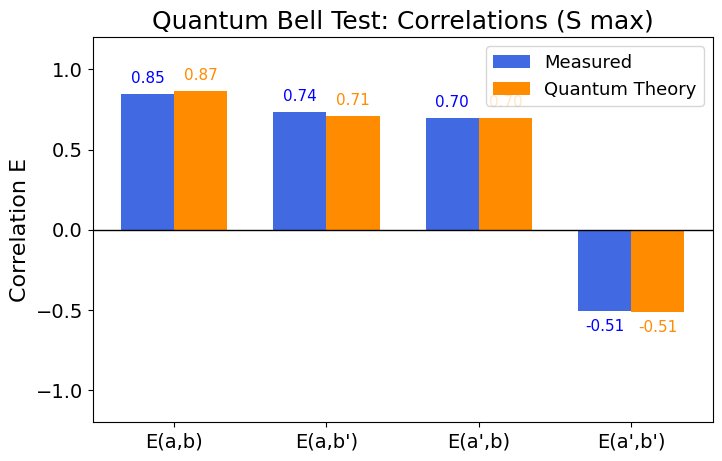

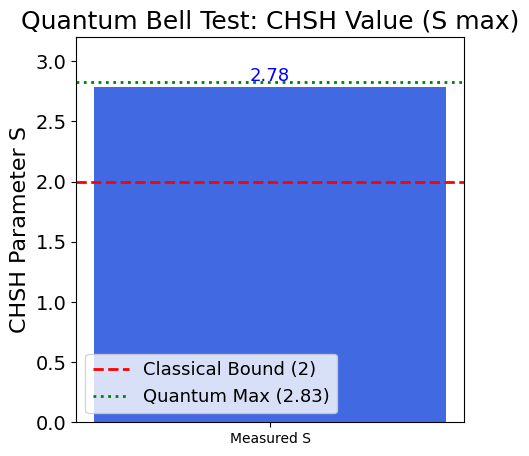

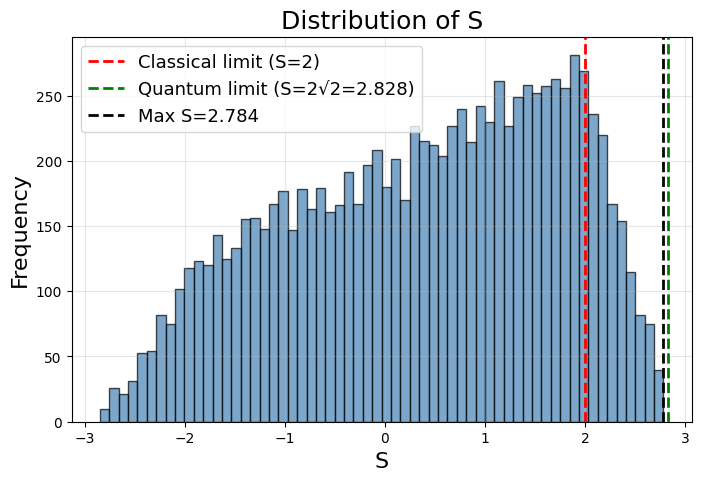

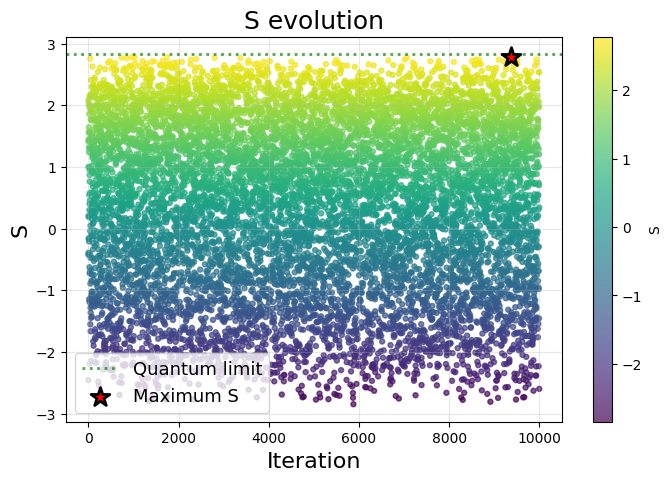

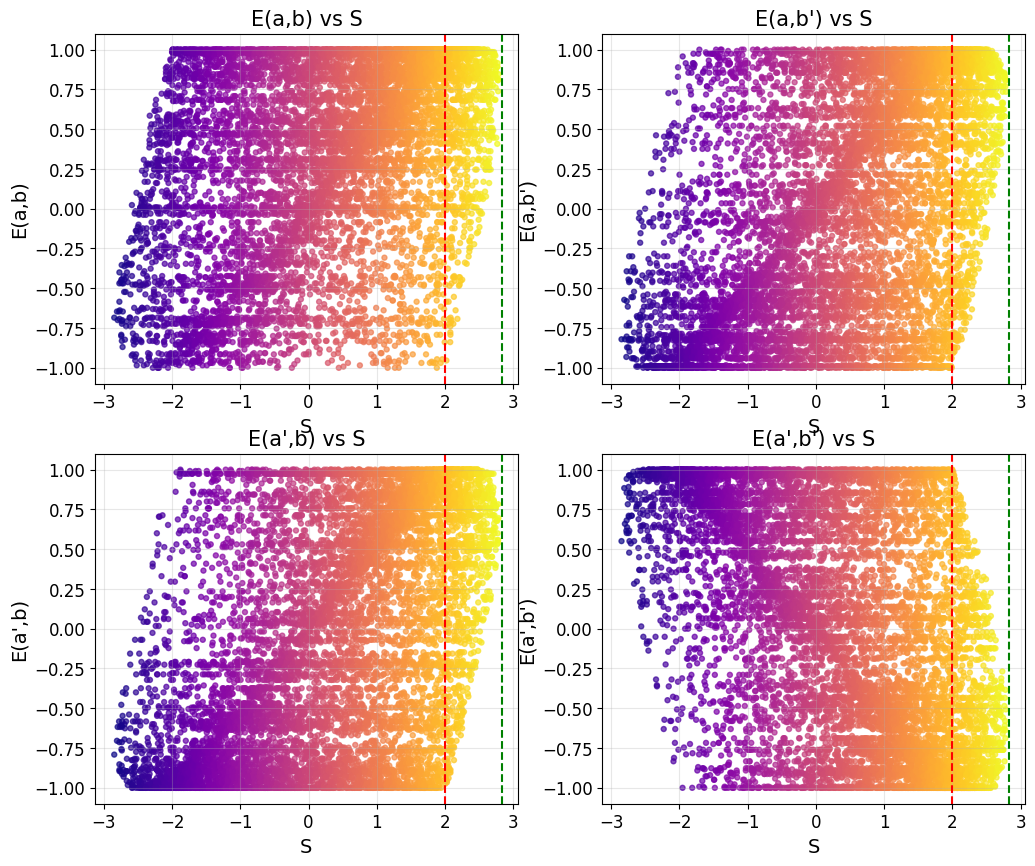

In [ ]:
def analizar_resultados(resultados_df):
    import matplotlib.pyplot as plt
    import numpy as np

    # --- Find maximum S ---
    idx_max = resultados_df['S'].idxmax()
    opt = resultados_df.loc[idx_max]
    
    # --- Print optimal configuration ---
    print(f"\n{'='*60}")
    print("OPTIMAL CONFIGURATION:")
    print(f"Bases: a, a' = {opt['a']:.2f}, {opt['ap']:.2f}, b, b' = {opt['b']:.2f}, {opt['bp']:.2f}")
    print(f"ao=[{opt['a']:.1f}, {opt['ap']:.1f}]")
    print(f"bo=[{opt['b']:.1f}, {opt['bp']:.1f}]")
    print("\nMeasured correlations:")
    print(f"  E(a,b)={opt['E_ab']:.3f}  E(a,b')={opt['E_abp']:.3f}  E(a',b)={opt['E_apb']:.3f}  E(a',b')={opt['E_apbp']:.3f}")
    print("GENERAL STATISTICS:")
    print(f"{'='*60}")
    print(f"  Max S:   {resultados_df['S'].max():.4f}")
    print(f"  Bell violation (S>2): {len(resultados_df[resultados_df['S'] > 2.0])} ({100*len(resultados_df[resultados_df['S'] > 2.0])/len(resultados_df):.1f}%)")
    print(f"  Near maximum (S>2.7): {len(resultados_df[resultados_df['S'] > 2.7])} ({100*len(resultados_df[resultados_df['S'] > 2.7])/len(resultados_df):.1f}%)")
    print(f"{'='*60}\n")

    # --- Correlation Bar Plot (S max) ---
    labels = ["E(a,b)", "E(a,b')", "E(a',b)", "E(a',b')"]
    measured = [opt['E_ab'], opt['E_abp'], opt['E_apb'], opt['E_apbp']]
    theoretical = [opt['E_ab_theo'], opt['E_abp_theo'], opt['E_apb_theo'], opt['E_apbp_theo']]
    x = np.arange(len(labels))
    bar_width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - bar_width/2, measured, bar_width, label="Measured", color="royalblue")
    plt.bar(x + bar_width/2, theoretical, bar_width, label="Quantum Theory", color="darkorange")
    plt.axhline(0, color="black", linewidth=1)
    plt.xticks(x, labels, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Correlation E", fontsize=16)
    plt.title("Quantum Bell Test: Correlations (S max)", fontsize=18)
    plt.legend(fontsize=13)
    for i, val in enumerate(measured):
        plt.text(i - bar_width/2, val + 0.05*np.sign(val), f"{val:.2f}",
                 ha="center", va="bottom" if val>=0 else "top", fontsize=11, color="blue")
    for i, val in enumerate(theoretical):
        plt.text(i + bar_width/2, val + 0.05*np.sign(val), f"{val:.2f}",
                 ha="center", va="bottom" if val>=0 else "top", fontsize=11, color="darkorange")
    plt.ylim(-1.2, 1.2)
    plt.savefig("correlations_S_max.pdf")
    plt.show()

    # --- CHSH S Bar Plot (S max) ---
    S = opt['S']
    plt.figure(figsize=(5,5))
    plt.bar(["Measured S"], [S], color="royalblue", width=0.4)
    plt.axhline(2, color="red", linestyle="--", linewidth=2, label="Classical Bound (2)")
    plt.axhline(2*np.sqrt(2), color="green", linestyle=":", linewidth=2, label="Quantum Max (2.83)")
    plt.ylabel("CHSH Parameter S", fontsize=16)
    plt.title("Quantum Bell Test: CHSH Value (S max)", fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)
    plt.text(0, S + 0.05, f"{S:.2f}", ha="center", fontsize=13, color="blue")
    plt.ylim(0, 3.2)
    plt.savefig("CHSHvalue_S_max.pdf")
    plt.show()

    # --- Histogram of S (all runs) ---
    plt.figure(figsize=(8,5))
    plt.hist(resultados_df['S'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)
    plt.axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='Classical limit (S=2)')
    plt.axvline(x=2.828, color='green', linestyle='--', linewidth=2, label='Quantum limit (S=2√2=2.828)')
    plt.axvline(x=resultados_df['S'].max(), color='black', linestyle='--', linewidth=2, label=f'Max S={resultados_df["S"].max():.3f}')
    plt.xlabel('S', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title('Distribution of S', fontsize=18)
    plt.legend(fontsize=13)
    plt.grid(alpha=0.3)
    plt.savefig("Distribution_S.pdf")
    plt.show()

    # --- Evolution of S (all runs) ---
    plt.figure(figsize=(8,5))
    scatter = plt.scatter(resultados_df['iter'], resultados_df['S'], 
                         c=resultados_df['S'], cmap='viridis', s=13, alpha=0.7)
    plt.axhline(2*np.sqrt(2), color='green', linestyle=':', linewidth=2, alpha=0.7, label='Quantum limit')
    plt.scatter(opt['iter'], opt['S'], color='red', s=200, marker='*', 
               edgecolors='black', linewidths=2, zorder=5, label='Maximum S')
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('S', fontsize=16)
    plt.title('S evolution', fontsize=18)
    plt.colorbar(scatter, label='S')
    plt.grid(alpha=0.3)
    plt.legend(fontsize=13)
    plt.savefig("AllModels_S.pdf")
    plt.show()
    
    # --- Correlations vs S (all runs) ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    all_labels = ["E(a,b)", "E(a,b')", "E(a',b)", "E(a',b')"]
    all_Es = [ 'E_ab', 'E_abp', 'E_apb', 'E_apbp' ]
    all_titles = [
        "E(a,b) vs S",
        "E(a,b') vs S",
        "E(a',b) vs S",
        "E(a',b') vs S"
    ]
    for idx, (ax, Ename, title) in enumerate(zip(axes.flat, all_Es, all_titles)):
        ax.scatter(resultados_df['S'], resultados_df[Ename],
                   c=resultados_df['S'], cmap='plasma', s=13, alpha=0.7)
        ax.axvline(x=2.0, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(x=2.828, color='green', linestyle='--', linewidth=1.5)
        ax.set_xlabel('S', fontsize=14)
        ax.set_ylabel(all_labels[idx], fontsize=14)
        ax.set_ylim(-1.1, 1.1)
        ax.set_title(title, fontsize=15)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=12)


    plt.savefig("E_S.pdf")
    plt.show()
analizar_resultados(resultados)
